#  ModelagemdotrânsitoplanetáriodoexoplanetaKepler-8b

Este projeto foi desenvolvido como [**Trabalho de Conclusão de Curso (TCC)**](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwjawYuO--6NAxUGuJUCHaSYIucQFnoECBMQAQ&url=https%3A%2F%2Fwww.unifal-mg.edu.br%2Ffisica%2Fwp-content%2Fuploads%2Fsites%2F110%2F2022%2F10%2FTCC_Joao-Carlos-Pereira-Alves.pdf&usg=AOvVaw0pouHROqZMf-S_zJFthqI-&opi=89978449) da minha graduação em **Física pela Universidade Federal de Alfenas (UNIFAL-MG)**, e foi **[defendido e aprovado](https://www.unifal-mg.edu.br/fisica/wp-content/uploads/sites/110/2022/10/TCCApres_Joao-Carlos-Pereira-Alves.pdf) em [abril de 2021](https://www.unifal-mg.edu.br/fisica/2021-tcc-apresentados/)**.

Ele marca o início da minha jornada com programação em Python, modelagem matemática e análise de dados astronômicos, e representa uma das minhas primeiras experiências práticas com ciência de dados.

**Resumo:** Neste trabalho apresentamos um estudo realizado a partir da modelagem do trânsito planetário do exoplaneta Kepler-8b. Apresentamos a técnica de trânsito planetário e uma descrição dos parâmetros físicos que podem ser estimados a partir da modelagem do trânsito. Descrevemos a metodologia para a obtenção dos dados do telescópio espacial Kepler e o processo de desenvolvimento de um código para simular acurva de luz do trânsito e a partir dele estimar alguns parâmetros do exoplaneta. Nos resultados apresentamos o ajuste do modelo aos dados de Kepler-8b e os parâmetros estimados. A comparação com a literatura nos mostrou que o algoritmo proposto produz resultados compatíveis com os já publicados.

## Instalando e importando as bibliotecas

In [1]:
! python -m pip install lightkurve --upgrade

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   --------------------- ------------------ 6.0/11.1 MB 33.5 MB/s eta 0:00:01
   ---------------------------------------- 11.1/11.1 MB 30.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   ---------------------------------------- 1.1/1.1 MB 26.2 MB/s eta 0:00:00
  Created wheel for fbpca: filename=fbpca-1.0-py3-none-any.whl size=11389 sha256=c61f9159a1666ee4da47149e2fba6003647ca290af0ae84eb627ae1d86b56527
  Stored in directory: c:\users\joaoc\appdata\local\pip\cache\wheels\04\15\cd\2f622795b09e83471a3be5d2581cd9cf96a6ec7aa78e8deffe
  Created wheel for memoization: filename=memoization-0.4.0-py3-none-any.whl size=50516 sha256=8affbb1af62b8dd04e9eaf2c1f311582db3545d2a86987d48ad4f

In [2]:
! pip install astropy

In [1]:
#Importar as bibliotecas utilziadas
import numpy as np
from numpy import arccos, sqrt, pi, clip, select, finfo
import lightkurve as lk
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.timeseries import BoxLeastSquares

C:\Users\joaoc\anaconda3\Lib\site-packages\lightkurve\prf\__init__.py:7: UserWarning: Warning: the tpfmodel submodule is not available without oktopus installed, which requires a current version of autograd. See #1452 for details.
  warnings.warn(


## Definindo a conta do ajuste (power2)

In [2]:
# Criando a função qpower2 que irá calcular valores do fluxo de brilho da estrela considerando os parâmetros 

def qpower2(z,p,c,alpha):
    
    I_0 = (alpha+2)/(pi*(alpha-c*alpha+2))
    g = 0.5*alpha

     #Calculando o fluxo para quando o exoplaneta está na parte interna do disco estelar 
    def q1(z,p,c,alpha): 
        zt = clip(abs(z), 0,1-p)
        s = 1-zt**2
        c0 = (1-c+c*s**g) 
        c2 = 0.5*alpha*c*s**(g-2)*((alpha-1)*zt**2-1)
        return 1-I_0*pi*p**2*(c0 + 0.25*p**2*c2 - 0.125*alpha*c*p**2*s**(g-1))

    #Calculando o fluxo para quando o exoplaneta está na borda do disco estelar
    def q2(z,p,c,alpha):
        zt = clip(abs(z), 1-p,1+p)
        d = clip((zt**2 - p**2 + 1)/(2*zt),0,1)
        ra = 0.5*(zt-p+d)
        rb = 0.5*(1+d)
        sa = clip(1-ra**2,finfo(0.0).eps,1)
        sb = clip(1-rb**2,finfo(0.0).eps,1)
        q = clip((zt-d)/p,-1,1)
        w2 = p**2-(d-zt)**2
        w = sqrt(clip(w2,finfo(0.0).eps,1))
        b0 = 1 - c + c*sa**g
        b1 = -alpha*c*ra*sa**(g-1)
        b2 = 0.5*alpha*c*sa**(g-2)*((alpha-1)*ra**2-1)
        a0 = b0 + b1*(zt-ra) + b2*(zt-ra)**2
        a1 = b1+2*b2*(zt-ra)
        aq = arccos(q)
        J1 = ( (a0*(d-zt)-(2/3)*a1*w2 + 0.25*b2*(d-zt)*(2*(d-zt)**2-p**2))*w + (a0*p**2 + 0.25*b2*p**4)*aq )
        J2 = alpha*c*sa**(g-1)*p**4*(0.125*aq + (1/12)*q*(q**2-2.5)*sqrt(clip(1-q**2,0,1)) )
        d0 = 1 - c + c*sb**g
        d1 = -alpha*c*rb*sb**(g-1)
        K1 = ((d0-rb*d1)*arccos(d) + ((rb*d+(2/3)*(1-d**2))*d1 - d*d0)*sqrt(clip(1-d**2,0,1)) )
        K2 = (1/3)*c*alpha*sb**(g+0.5)*(1-d)
        return 1 - I_0*(J1 - J2 + K1 - K2)
        
    #Retorna o resultado de q1, q2 ou 1 dependendo do valor de z e p 
    return select([abs(z) <= (1-p), abs(z-1) < p], [q1(z, p, c, alpha), q2(z, p, c, alpha)], default=1)

## Descobrindo o período orbital

In [14]:
# Buscando o valor do período orbital do exoplaneta Kepler-8b
lc = lk.search_lightcurve("Kepler-8",cadence="long", quarter=4).download()
lc_n = lc.normalize()
periodogram = BoxLeastSquares.from_timeseries(lc_n, 'flux')  
results = periodogram.autopower(0.2 * u.day)
best = np.argmax(results.power)  

period = results.period[best]  
transit_time = results.transit_time[best]  
lc_n_folded = lc_n.fold(period=period, epoch_time=transit_time)
period

C:\Users\joaoc\anaconda3\Lib\site-packages\lightkurve\search.py:420: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


<Quantity 3.52143789 d>

## Baixando os dados e realizando o corte no gráfico da curva de luz

C:\Users\joaoc\anaconda3\Lib\site-packages\lightkurve\search.py:420: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


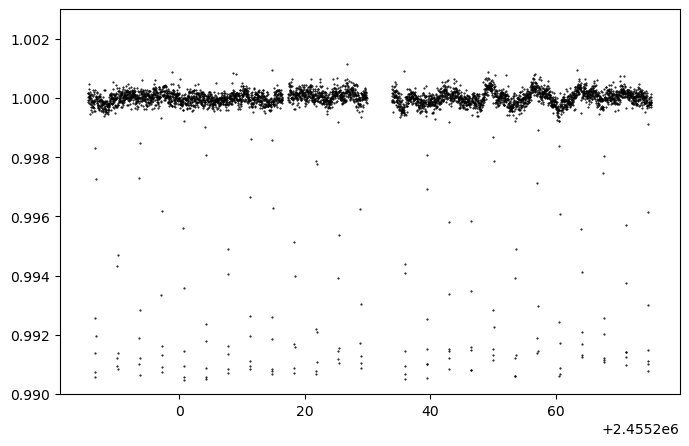

In [11]:
lc = lk.search_lightcurve("Kepler-8",cadence="long", quarter=4).download()
lc_n = lc.normalize()
periodogram = BoxLeastSquares.from_timeseries(lc_n, 'flux')  
results = periodogram.autopower(0.2 * u.day)
best = np.argmax(results.power)  

period = results.period[best]  
transit_time = results.transit_time[best]  
lc_n_folded = lc_n.fold(period=period, epoch_time=transit_time)

plt.plot(lc_n.time.jd, lc_n['flux'], 'k.', markersize=1)
#plt.xlim(-1, 1)
plt.ylim(0.990, 1.003)
plt.savefig("Cut_1.png", dpi=300) 
plt.show()
#plt.xlim(35, 40)
#lc_n.to_excel("Kepler8.xlsx")

C:\Users\joaoc\anaconda3\Lib\site-packages\lightkurve\search.py:420: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


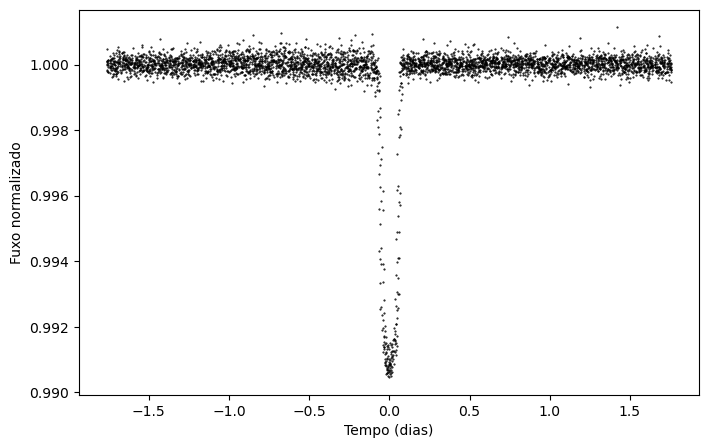

In [10]:
lc = lk.search_lightcurve("Kepler-8",cadence="long", quarter=4).download()
lc_n = lc.normalize()
periodogram = BoxLeastSquares.from_timeseries(lc_n, 'flux')  
results = periodogram.autopower(0.2 * u.day)
best = np.argmax(results.power)  

period = results.period[best]  
transit_time = results.transit_time[best]  
lc_n_folded = lc_n.fold(period=period, epoch_time=transit_time)

plt.plot(lc_n_folded.time.jd, lc_n_folded['flux'], 'k.', markersize=1)
#plt.xlim(-0.15, 0.15)
plt.xlabel('Tempo (dias)')
plt.ylabel('Fuxo normalizado')
plt.rcParams['figure.figsize'] = [8, 5]
plt.savefig("Cut_2.png", dpi=300) 
plt.show()

C:\Users\joaoc\anaconda3\Lib\site-packages\lightkurve\search.py:420: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


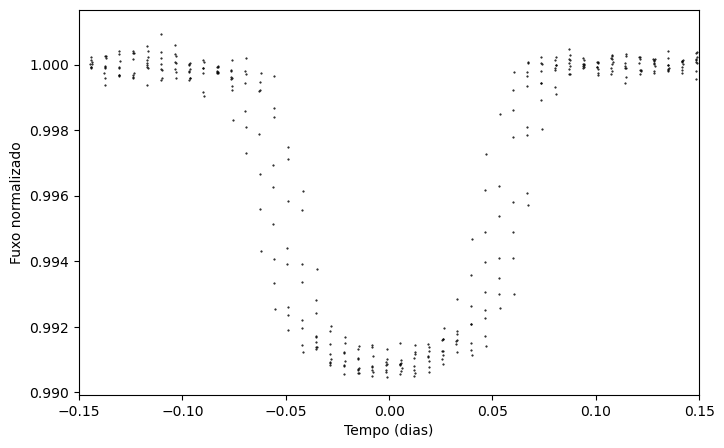

In [12]:
lc = lk.search_lightcurve("Kepler-8",cadence="long", quarter=4).download()
lc_n = lc.normalize()
periodogram = BoxLeastSquares.from_timeseries(lc_n, 'flux')  
results = periodogram.autopower(0.2 * u.day)
best = np.argmax(results.power)  

period = results.period[best]  
transit_time = results.transit_time[best]  
lc_n_folded = lc_n.fold(period=period, epoch_time=transit_time)

plt.plot(lc_n_folded.time.jd, lc_n_folded['flux'], 'k.', markersize=1)
plt.xlim(-0.15, 0.15)
plt.xlabel('Tempo (dias)')
plt.ylabel('Fuxo normalizado')
plt.rcParams['figure.figsize'] = [8, 5]
plt.savefig("Cut_3.png", dpi=300) 
plt.show()

## Modelagem do trânsito planetário (Kepler-8b)

### Definindo o plote do gráfico do ajuste, colocando os valores dos parâmetros que melhor modela a curva de luz.

In [3]:
def ajuste(p, c, alpha, pp, aR, inc):
    
    inc_rad=(inc*pi)/180
    b=aR*np.cos(inc_rad)
    flux=[]
    fase=np.arange(-0.15, 0.15, 0.00014985014985014985)

#Loop de valores de z calculados (parte da direita)
    i=0
    while i < 1001:
        t=0+i*(pp/500)
        nu=(2*pi*(t-0))/pp
        nur=(nu*pi)/180
        z = aR*sqrt(1-((np.cos(nur))**2)*(np.sin(inc_rad))**2)
        zz = z-aR*sqrt(1-(np.sin(inc_rad))**2)
        flux.append(qpower2(z,p,c,alpha))
        i+=1

    return plt.scatter(fase,flux[::-1]+flux, s=0.1, color='red')

# Entrada de parâmetros definidos pela literatura e estimados. 
 
# c=0.706                                                 Extraido da tabela disponível no CDS
# alpha=0.632                                             Extraido da tabela disponível no CDS
# pp=3.52                                                 Estimado a partir da curva de transito
 
#Entrada de parâmetros variaves afim de melhorar o ajuste da curva (Pode modificar estes para obter a melhor modelagem)
 
# p=0.095                                               Estipulado manualmente para o melhor ajuste
#aR=6.95                                                Calculado a partir da 3 Lei de Kepler
#inc=(84*pi)/180                                        Estipulado manualmente para o melhor ajuste e convertido para radianos

C:\Users\joaoc\anaconda3\Lib\site-packages\lightkurve\search.py:420: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


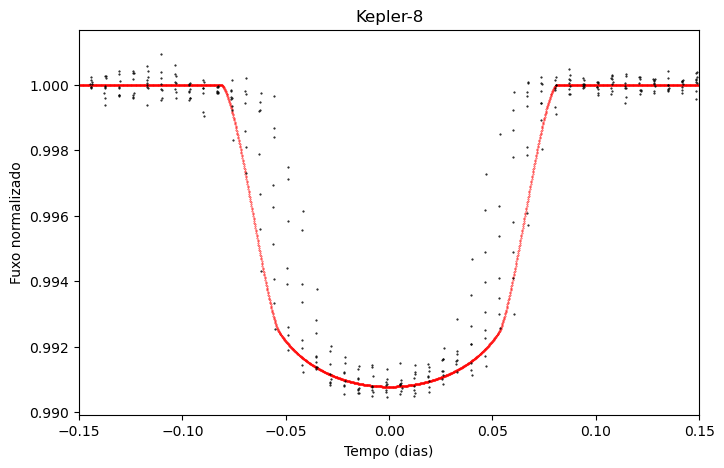

In [13]:
lc = lk.search_lightcurve("Kepler-8",cadence="long", quarter=4).download()
lc_n = lc.normalize()
periodogram = BoxLeastSquares.from_timeseries(lc_n, 'flux')  
results = periodogram.autopower(0.2 * u.day)
best = np.argmax(results.power)  

period = results.period[best]  
transit_time = results.transit_time[best]  
lc_n_folded = lc_n.fold(period=period, epoch_time=transit_time)

ajuste(0.095, 0.706, 0.632, 3.52, 6.95, 84)           # Dados usados no TCC

#Plotando os dados baixados e a modelagem realizada
plt.plot(lc_n_folded.time.jd, lc_n_folded['flux'], 'k.', markersize=1)
plt.xlim(-0.15, 0.15)
plt.xlabel('Tempo (dias)')
plt.ylabel('Fuxo normalizado')
plt.rcParams['figure.figsize'] = [8, 5]
plt.title('Kepler-8')
plt.savefig("Model.png", dpi=300) 
plt.show()